In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(12345) 

In [3]:
# loading data
data_stocks_dir = ''
df_micro = pd.read_pickle(data_stocks_dir + 'returns_chars_panel.pkl')
df_macro = pd.read_pickle(data_stocks_dir + 'macro_timeseries.pkl')
df = pd.merge(df_micro,df_macro,on='date',how='left',suffixes=['','_macro']) 

df.head()

,date,permno,excess_ret,ret,rfree,mvel1,beta,betasq,chmom,dolvol,...,ep_macro,b/m,crsp_spvw,svar,tbl,tms,dfy,dfr,ntis,infl
0,1986-02-01,10000,-0.262610,-0.257143,0.005467,-0.375440,0.0,0.0,0.0,0.000000,...,-2.675897,0.583517,0.004706,0.001920,0.0707,0.0251,0.0139,0.0070,-0.019172,0.002745
1,1986-03-01,10000,0.360335,0.365385,0.005050,-0.496811,0.0,0.0,0.0,0.000000,...,-2.747007,0.536377,0.076525,0.001089,0.0706,0.0135,0.0144,-0.0393,-0.017914,-0.002737
2,1986-04-01,10000,-0.103717,-0.098592,0.005125,-0.401783,0.0,0.0,0.0,-0.521182,...,-2.800518,0.519628,0.055832,0.001374,0.0656,0.0110,0.0150,-0.0514,-0.016420,-0.004575
3,1986-05-01,10000,-0.227831,-0.222656,0.005175,-0.435735,0.0,0.0,0.0,-0.439391,...,-2.781919,0.529714,-0.013348,0.002459,0.0606,0.0176,0.0140,0.0096,-0.024585,-0.001838
4,1986-06-01,10000,-0.009883,-0.005025,0.004858,-0.534203,0.0,0.0,0.0,-0.499678,...,-2.826589,0.503541,0.055326,0.001370,0.0615,0.0233,0.0120,0.0341,-0.021872,0.002762


In [4]:
# features and target
y = df['excess_ret'] 
X = df.drop(columns=['ret','excess_ret','rfree','permno','date']) # everything except return info and IDs

# samples
training = (df['date'] <= '1974-12-31') 
validation = (df['date'] > '1974-12-31') & (df['date'] <= '1986-12-31') 
test = (df['date'] > '1986-12-31') & (df['date'] <= '1987-12-31') 

X_train, y_train = X.loc[training].values, y.loc[training].values 
X_val, y_val = X.loc[validation].values, y.loc[validation].values 
X_test, y_test = X.loc[test].values, y.loc[test].values 

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.regularizers import L1
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
tf.random.set_seed(12345)

# hypers
hidden_layers = [32]
alpha = 1e-4
lambda_1 = 0.01
B = 512
pat = 5

def fit_nn(hidden_layers,alpha,lambda_1,B,pat):

    # keras setup
    model = Sequential()
    penalty = L1(lambda_1)

    input_dim = X.shape[1]
    for layer in hidden_layers:
        model.add(Dense(layer,input_dim = input_dim,
                        kernel_regularizer = penalty,
                        kernel_initializer = 'he_normal'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        input_dim = layer

    model.add(Dense(1,input_dim = X.shape[1],
                    kernel_regularizer = penalty,
                    kernel_initializer = 'he_normal'))

    model.compile(loss = 'mse', 
                  optimizer = Adam(learning_rate = alpha),
                  metrics=['mean_squared_error'])

    model.summary()

    # training
    history = model.fit(X_train,y_train, validation_data=(X_val,y_val), 
                     epochs=50, 
                     batch_size=B, 
                     callbacks=[EarlyStopping(patience=pat,restore_best_weights=True)], 
                     verbose=0)
    
    return history, model

# history , model = fit_nn(hidden_layers,alpha,lambda_1,B,pat)

# # learning curves
# plt.figure(figsize=(12,8))
# plt.plot(history.history['mean_squared_error'])
# plt.plot(history.history['val_mean_squared_error'])
# plt.legend(['Training MSE','Validation MSE'])

# # testing
# mse = ((model.predict(X_test).squeeze() - y_test)**2).mean()
# mse_0 = (y_test ** 2).mean()
# r2oos = 1 - mse / mse_0
# print('R2 out of sample: %.4f' % r2oos)

In [6]:
history.history['val_mean_squared_error']

NameError: name 'history' is not defined

In [7]:
alphas = [10**(-k) for k in [1,2,3,4,5]]
lambdas = [10**(-k) for k in [1,2,3,4,5]]

MSE = pd.DataFrame(columns=alphas, index = lambdas)

for alpha in alphas:
    
    print('current alpha = %.5f' % alpha)
    
    for lambda_1 in lambdas:
        
        print('current lambda1 = %.5f' % lambda_1)
        
        history , model = fit_nn(hidden_layers,alpha,lambda_1,B,pat)
        mse_val = ((model.predict(X_val).squeeze() - y_val)**2).mean()
        print('validation MSE = %.5f' % mse_val)

        MSE.loc[lambda_1,alpha] = mse_val

current alpha = 0.10000
current lambda1 = 0.10000
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                3392      
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
activation (Activation)      (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 3,553
Trainable params: 3,489
Non-trainable params: 64
_________________________________________________________________


In [30]:
MSE.index.rename('lambda',inplace=True)
MSE.columns.rename('alpha',inplace=True)
MSE

alpha,0.10000,0.01000,0.00100,0.00010,0.00001
lambda,,,,,
0.10000,0.026793,0.026693,0.026659,0.026612,0.026633
0.01000,0.026361,0.026563,0.026598,0.026608,0.026633
0.00100,0.026674,0.026733,0.027395,0.027037,0.028147
0.00010,0.026891,0.026965,0.027143,0.02762,0.029521
0.00001,0.026743,0.027281,0.028036,0.027268,0.031905


<AxesSubplot:xlabel='lambda'>

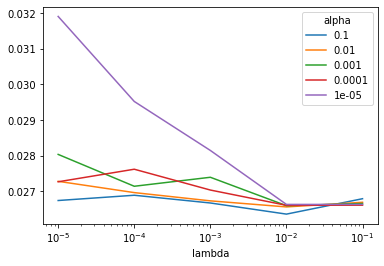

In [32]:
MSE.plot(logx=True)